# New York City Taxi Ride Duration Prediction

In this case study, we will build a predictive model to predict the duration of taxi ride. We will do the following steps:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Define the outcome variable - the variable we are trying to predict.
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system.
  


Allocate at least 2-3 hours to go through this case study end-to-end

# Install Dependencies 
<p>If you have not done so already, download this repository <a href="https://github.com/Featuretools/DSx/archive/master.zip">from git</a>. Once you have downloaded this archive, unzip it and cd into the directory from the command line. Next run the command ``./install_osx.sh`` if you are on a mac or ``./install_linux.sh`` if you are on linux. This should install all of the dependencies.</p>
<p> If you are on a windows machine, open the requirements.txt folder and make sure to install each of the dependencies listed (featuretools, jupyter, pandas, sklearn, numpy) </p>
<p> Once you have installed all of the dependencies, open this notebook. On Mac and Linux, navigate to the directory that you downloaded from git and run ``jupyter notebook`` to be taken to this notebook in your default web browser. When you open the NewYorkCity_taxi_case_study.ipynb file in the web browser, you can step through the code by clicking the ``Run`` button at the top of the page. If you have any questions for how to use <a href="http://jupyter.org/">Jupyter</a>, refer to google or the discussion forum.</p>

# Running the Code

In [1]:
import featuretools as ft
import utils
from utils import load_nyc_taxi_data, compute_features, preview, feature_importances
from sklearn.ensemble import GradientBoostingRegressor
from featuretools.primitives import (Weekend, Minute, Hour, Day, Week, Month,
                                     Weekday, Weekend, Count, Sum, Mean, Median, Std, Min, Max)
import numpy as np
ft.__version__
%load_ext autoreload
%autoreload 2

# Step 1: Download and load the raw data as pandas dataframes
<p>If you have not yet downloaded the data it can be downloaded <a href="https://s3.amazonaws.com/mit-dsx-data/nyc-taxi-data.zip">from S3</a>. Once you have downloaded the archive, unzip it and place the nyc-taxi-data folder in the same directory as this script. 
</p>

In [2]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
672146,672146,1,2016-04-29 07:01:31,2016-04-29 07:15:46,1,3.30,-73.949951,40.784653,-73.982536,40.755470,1,855.0,C,AA
672147,672147,2,2016-04-29 07:01:43,2016-04-29 07:09:15,1,1.14,-73.967331,40.757370,-73.954277,40.765282,1,452.0,N,K
672148,672148,1,2016-04-29 07:01:46,2016-04-29 07:07:54,1,1.10,-74.003082,40.727509,-73.984703,40.724377,1,368.0,AB,AC
672149,672149,2,2016-04-29 07:01:46,2016-04-29 07:06:48,2,1.40,-73.990158,40.772350,-73.982147,40.759800,1,302.0,AR,AA
672150,672150,1,2016-04-29 07:01:59,2016-04-29 07:07:33,1,1.20,-73.983681,40.746677,-73.971703,40.762463,2,334.0,AO,A
672151,672151,2,2016-04-29 07:02:11,2016-04-29 07:15:24,2,2.13,-73.994209,40.750999,-73.969391,40.761539,1,793.0,D,AK
672152,672152,1,2016-04-29 07:02:11,2016-04-29 07:06:44,1,1.00,-73.983276,40.770985,-73.980110,40.760666,1,273.0,AR,A
672153,672153,2,2016-04-29 07:02:13,2016-04-29 07:08:36,1,1.17,-73.980141,40.743168,-73.983391,40.754665,1,383.0,Y,AA
672154,672154,1,2016-04-29 07:02:16,2016-04-29 07:04:07,1,0.50,-73.965973,40.765381,-73.970558,40.758724,1,111.0,AK,N


The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighboorhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighboorhood where the trip ended

# Step 2: Prepare the Data
Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighboorhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighboorhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In [featuretools (automated feature engineering software package)](https://www.featuretools.com/), we specify the list of entities and relationships as follows: 


In [3]:
entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [4]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
56311,56311,2016-01-12 00:00:25
698765,698765,2016-05-03 18:54:53
698766,698766,2016-05-03 18:55:37
698767,698767,2016-05-03 18:55:38
698768,698768,2016-05-03 18:55:49
698769,698769,2016-05-03 18:55:58
698770,698770,2016-05-03 18:56:22
698771,698771,2016-05-03 18:56:24
698772,698772,2016-05-03 18:56:51
698773,698773,2016-05-03 18:56:56


### **Comments:**
* The data contains trips with pickup_datetimne from 2016/01/01 to 2016/06/30
* Cutoff Time criteria: only select trips that started after January 12th, 2016
* Cutoff times make sense. They are needed to make the duration prediction using data before the trip starts; that is why pickup_datetime timestamp is used as cutoff times

# Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

# Create transform features using transform primitives

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

In [5]:
trans_primitives = [Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [6]:
print "Number of features: %d" % len(features)
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: dropoff_neighborhood>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: trip_duration>,
 <Feature: trip_distance>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>]

Now let's compute the features. 

In [7]:
feature_matrix = compute_features(features, cutoff_time)

Progress: 100%|██████████| 5/5 [00:13<00:00,  2.79s/cutoff time]
Finishing computing...


In [8]:
preview(feature_matrix, 5)

,IS_WEEKEND(dropoff_datetime),trip_distance,passenger_count,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,...,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = R,pickup_neighborhood = O
id,,,,,,,,,,,,,,,,,,,,,
56311,False,1.61,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
691284,False,0.61,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
691285,False,0.88,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
691286,False,1.90,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
691288,False,1.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Step 4: Build the Model

To build a model, we
* Seperate the data into a porition for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``GradientBoostingRegressor``

In [9]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

In [10]:
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.4925            1.83m
         2           0.4333            1.82m
         3           0.3843            1.82m
         4           0.3446            1.82m
         5           0.3119            1.78m
         6           0.2852            1.76m
         7           0.2634            1.75m
         8           0.2454            1.72m
         9           0.2305            1.69m
        10           0.2183            1.68m
        20           0.1666            1.47m
        30           0.1558            1.26m
        40           0.1514            1.04m
        50           0.1488           49.64s
        60           0.1472           38.92s
        70           0.1458           28.50s
        80           0.1448           18.70s
        90           0.1440            9.21s
       100           0.1433            0.00s


0.72200175704571445

# Step 5: Adding more Transform Primitives

* Add ``Minute``, ``Hour``, ``Week``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

In [11]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [12]:
print "Number of features: %d" % len(features)
features

Number of features: 25


[<Feature: passenger_count>,
 <Feature: dropoff_neighborhood>,
 <Feature: payment_type>,
 <Feature: vendor_id>,
 <Feature: pickup_neighborhood>,
 <Feature: trip_duration>,
 <Feature: trip_distance>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: IS_WEEKEND(dropoff_datetime)>]

Now let's compute the features. 

In [13]:
feature_matrix = compute_features(features, cutoff_time)

Progress: 100%|██████████| 5/5 [00:18<00:00,  3.78s/cutoff time]
Finishing computing...


In [14]:
preview(feature_matrix, 10)

,WEEKDAY(dropoff_datetime),dropoff_neighborhoods.latitude,MINUTE(dropoff_datetime),WEEK(dropoff_datetime),passenger_count,trip_duration,HOUR(pickup_datetime),pickup_neighborhoods.latitude,vendor_id,dropoff_neighborhoods.longitude,...,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AO,dropoff_neighborhood = AK,HOUR(dropoff_datetime),IS_WEEKEND(dropoff_datetime),trip_distance
id,,,,,,,,,,,,,,,,,,,,,
56311,1,40.721435,11,2,1,645.0,0,40.720245,2,-73.998366,...,0,0,0,0,0,0,0,0,False,1.61
691284,0,40.721435,24,18,2,160.0,12,40.729652,2,-73.998366,...,0,0,0,0,0,0,0,12,False,0.61
691285,0,40.785005,27,18,2,295.0,12,40.776270,2,-73.976050,...,0,0,0,0,0,0,0,12,False,0.88
691286,0,40.757707,48,18,1,1573.0,12,40.742531,1,-73.986446,...,0,0,0,0,0,0,0,12,False,1.90
691288,0,40.761087,30,18,1,404.0,12,40.747126,1,-73.995736,...,0,0,0,0,0,0,0,12,False,1.00
691289,0,40.761492,55,18,1,1906.0,12,40.721435,2,-73.975899,...,0,0,0,0,0,0,0,12,False,3.24
691290,0,40.764723,26,18,1,156.0,12,40.764723,1,-73.966696,...,0,0,0,0,0,0,1,12,False,0.10
691291,0,40.776270,37,18,1,827.0,12,40.766809,1,-73.982322,...,0,0,0,0,0,0,0,12,False,1.60
691292,0,40.764723,39,18,1,883.0,12,40.752186,1,-73.966696,...,0,0,0,0,0,0,1,12,False,1.50


# Step 6: Build the new model

In [15]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

In [16]:
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train,y_train)
model.score(X_test,y_test)

      Iter       Train Loss   Remaining Time 
         1           0.4925            2.44m
         2           0.4333            2.42m
         3           0.3843            2.38m
         4           0.3444            2.36m
         5           0.3117            2.35m
         6           0.2848            2.36m
         7           0.2620            2.32m
         8           0.2435            2.30m
         9           0.2282            2.27m
        10           0.2152            2.23m
        20           0.1588            2.02m
        30           0.1415            1.71m
        40           0.1332            1.42m
        50           0.1283            1.14m
        60           0.1252           52.78s
        70           0.1227           38.70s
        80           0.1207           25.44s
        90           0.1191           12.51s
       100           0.1177            0.00s


0.7755608981558122

# Step 7: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

In [17]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [18]:
print "Number of features: %d" % len(features)
features

Number of features: 63


[<Feature: passenger_count>,
 <Feature: dropoff_neighborhood>,
 <Feature: payment_type>,
 <Feature: vendor_id>,
 <Feature: pickup_neighborhood>,
 <Feature: trip_duration>,
 <Feature: trip_distance>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: dropoff_neighborhoods.SUM(trips.trip_duration)>,
 <Feature: pickup_neighborhoods.STD(trips.trip

In [19]:
feature_matrix = compute_features(features, cutoff_time)

Progress: 100%|██████████| 5/5 [00:40<00:00,  8.12s/cutoff time]
Finishing computing...


In [20]:
preview(feature_matrix, 10)

,dropoff_neighborhoods.MAX(trips.trip_duration),pickup_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.MEDIAN(trips.trip_distance),HOUR(dropoff_datetime),dropoff_neighborhoods.COUNT(trips),DAY(pickup_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.SUM(trips.passenger_count),pickup_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.SUM(trips.passenger_count),...,pickup_neighborhoods.STD(trips.passenger_count),MONTH(pickup_datetime),pickup_neighborhoods.MEAN(trips.trip_duration),WEEK(pickup_datetime),dropoff_neighborhoods.MEAN(trips.trip_distance),MONTH(dropoff_datetime),payment_type,MINUTE(dropoff_datetime),WEEK(dropoff_datetime),dropoff_neighborhoods.MAX(trips.passenger_count)
id,,,,,,,,,,,,,,,,,,,,,
56311,3572.0,1.0,2.40,0,1396.0,12,40.720245,2283.0,2.517060,2375.0,...,1.331649,1,740.870871,2,2.495358,1,1,11,2,6.0
691284,3603.0,1.0,1.60,12,16736.0,2,40.729652,34521.0,2.099009,28154.0,...,1.310235,5,753.813680,18,2.338798,5,1,24,18,6.0
691285,3602.0,1.0,1.60,12,19017.0,2,40.776270,36299.0,2.111243,31836.0,...,1.315396,5,681.405688,18,2.176976,5,1,27,18,6.0
691286,3606.0,1.0,1.49,12,28805.0,2,40.742531,31158.0,2.137177,49208.0,...,1.330198,5,682.624440,18,2.365290,5,1,48,18,6.0
691288,3580.0,1.0,1.40,12,16985.0,2,40.747126,43543.0,2.382449,28197.0,...,1.319326,5,714.648716,18,2.067381,5,1,30,18,6.0
691289,3606.0,1.0,1.90,12,31541.0,2,40.721435,30913.0,4.278882,52591.0,...,1.315238,5,818.141251,18,2.102551,5,1,55,18,6.0
691290,3580.0,1.0,1.30,12,21894.0,2,40.764723,43212.0,1.846378,36175.0,...,1.315462,5,637.726834,18,1.732215,5,2,26,18,6.0
691291,3604.0,1.0,1.63,12,21272.0,2,40.766809,32656.0,2.206183,35282.0,...,1.332742,5,707.024093,18,2.061938,5,1,37,18,6.0
691292,3580.0,1.0,1.49,12,21894.0,2,40.752186,57862.0,2.488034,36175.0,...,1.306561,5,749.696305,18,1.732215,5,1,39,18,6.0


# Step 8: Build the new model

In [21]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

In [22]:
# note: this may take up to 30 minutes to run
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.4925            6.12m
         2           0.4333            5.95m
         3           0.3843            5.87m
         4           0.3444            5.85m
         5           0.3117            5.77m
         6           0.2848            5.68m
         7           0.2620            5.57m
         8           0.2435            5.51m
         9           0.2282            5.45m
        10           0.2152            5.37m
        20           0.1585            4.76m
        30           0.1420            4.04m
        40           0.1332            3.36m
        50           0.1271            2.72m
        60           0.1238            2.13m
        70           0.1211            1.58m
        80           0.1191            1.05m
        90           0.1176           31.11s
       100           0.1163            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0,
             verbose=True, warm_start=False)

# Step 9: Evalute on test data

In [23]:
model.score(X_test,y_test)

0.77808885638984859

we can also make predictions using our model

In [24]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier
y_pred[5:]

array([  557.67992664,   590.2602792 ,  1497.39684679, ...,  1063.48382696,
        1800.89361932,   739.60249439])

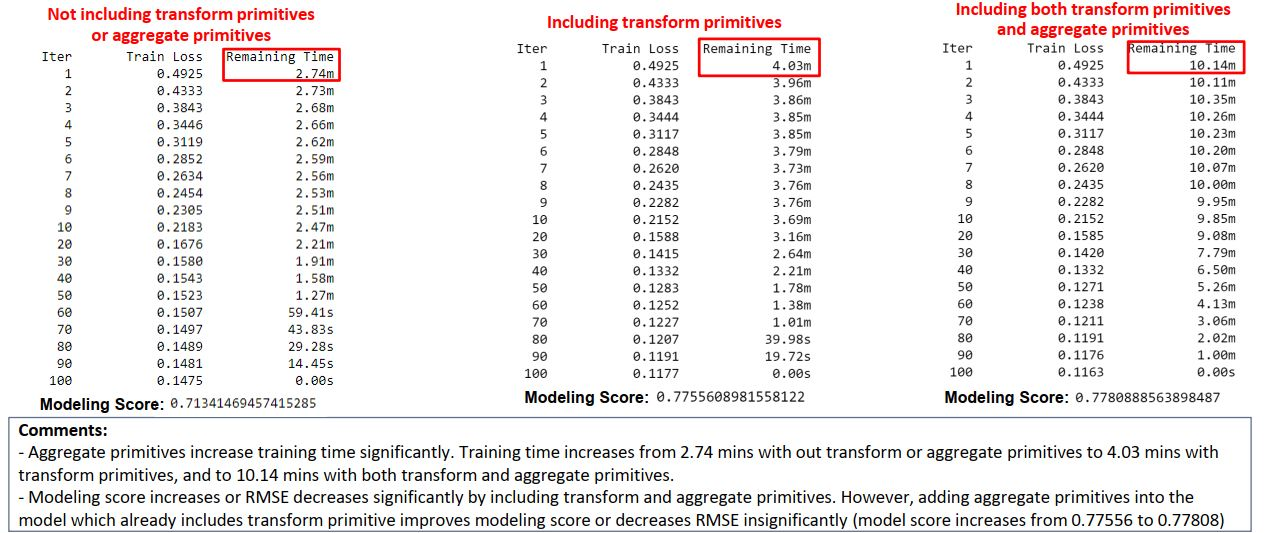

# Additional Analysis
<p>Let's look at how important each feature was for the model.</p>

In [25]:
feature_importances(model, feature_matrix.columns, n=15)

1: Feature: trip_distance, 0.314
2: Feature: HOUR(pickup_datetime), 0.126
3: Feature: HOUR(dropoff_datetime), 0.089
4: Feature: WEEKDAY(pickup_datetime), 0.052
5: Feature: dropoff_neighborhoods.latitude, 0.046
6: Feature: dropoff_neighborhoods.longitude, 0.036
7: Feature: dropoff_neighborhoods.STD(trips.trip_distance), 0.027
8: Feature: dropoff_neighborhoods.MIN(trips.passenger_count), 0.022
9: Feature: dropoff_neighborhoods.MEDIAN(trips.trip_duration), 0.022
10: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.021
11: Feature: IS_WEEKEND(pickup_datetime), 0.021
12: Feature: WEEKDAY(dropoff_datetime), 0.020
13: Feature: WEEK(pickup_datetime), 0.019
14: Feature: dropoff_neighborhoods.MEAN(trips.trip_duration), 0.019
15: Feature: MONTH(dropoff_datetime), 0.018


### Disclaimer: This work was a part of the courseworks in [MITxPro: Data Science and Big Data Analytics: Making Data-Driven Decisions](https://learn-xpro.mit.edu/data-science). All copyrights reserved by MIT.